In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
df.Customer_Id.nunique(), df.Invoice_Id.nunique(), df.Subscription_Type.nunique(), df.Month_Invoiced.nunique()

(29400, 790458, 5, 48)

In [6]:
df.Month_Invoiced.min(), df.Month_Invoiced.max()

('2014-01-31', '2017-12-31')

In [7]:
df.Month_Invoiced.dtypes

dtype('O')

In [8]:
#df['Month_Invoiced'] = pd.to_datetime(df.Month_Invoiced)
df = df.assign(ds = pd.to_datetime(df.Month_Invoiced))

In [9]:
df = df.sort_values('ds')

In [10]:
df = df.groupby(['ds'])[['Amount']].sum()

In [11]:
df.head()

,Amount
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [14]:
def prep_date():
    df = df.assign(ds = pd.to_datetime(df.Month_Invoiced))
    df = df.sort_values('ds')
    df = df.groupby(['ds'])[['Amount']].sum()
    return df

In [12]:
# continous variables = 'amount'
# categorical variables = 'customer_id', 'Invoice_Id', 'Subscription_Type'
target_var = "Amount"

In [15]:
df.shape

(48, 1)

# Split

In [24]:
def split():
    train_size = int(len(df) * .5)
    print(f"train = {train_size}")
    validate_size = int(len(df) * .3)
    print(f"validate = {validate_size}")
    test_size = int(len(df) - train_size - validate_size)
    print(f"test = {test_size}")
    validate_end_index = train_size + validate_size
    print(f"validate_end_index = {validate_end_index}")
    train = df[:train_size]
    validate = df[train_size : validate_end_index]
    test = df[validate_end_index : ]
    return train, validate, test

In [25]:
train, validate, test=split()

train = 24
validate = 14
test = 10
validate_end_index = 38


In [27]:
train.shape, validate.shape, test.shape

((24, 1), (14, 1), (10, 1))

In [29]:
def verify_split():
    print(len(train) + len(validate) + len(test) == len(df))
    print(df.head(1) == train.head(1))

In [30]:
verify_split()

True
            Amount
ds                
2014-01-31    True


In [31]:
# Plot

In [32]:
def plot_samples(target_var):
    '''
    this function will plot the train, validate and test values for a single variable across all dates. 
    '''
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)

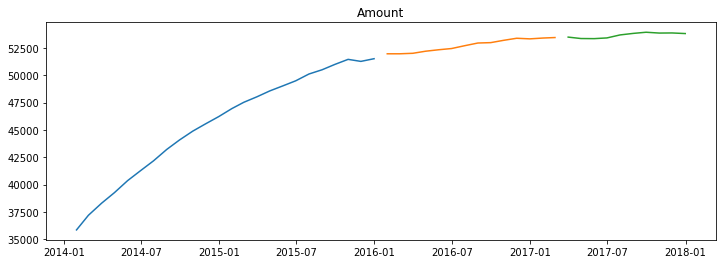

In [47]:
plot_samples(target_var)

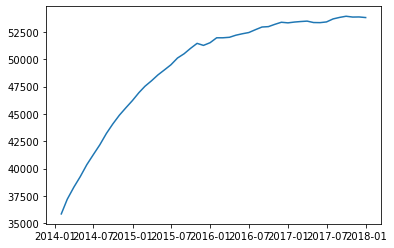

In [34]:
plt.plot(df.Amount)

In [37]:
def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values 
    and compute the mean_squared_error and then take the square root and round to 0 decimals.
    It will return the rmse, an integer.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [38]:
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '--RMSE: {:.0f}'.format(rmse))
    plt.show()

In [39]:
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [40]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string,
    and run the evaluate() function to compute the rmse,
    and append the data frame a row with the model_type, target_var, and rmse.
    It will return the new dataframe. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse':  [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

# Last Observed Value

In [48]:
# create var 'amt' with last observed value
amt = train['Amount'][-1:][0]
yhat_df = pd.DataFrame({'Amount': [amt]}, index = validate.index)
yhat_df.head(2)

,Amount
ds,
2016-01-31,51505.0
2016-02-29,51505.0


Amount --RMSE: 1343


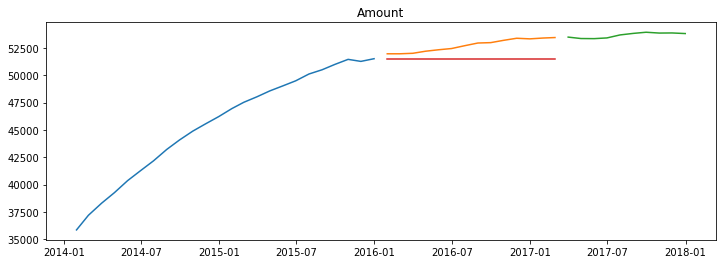

In [53]:
plot_and_eval(target_var)

In [54]:
# Evaluate

In [55]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

In [56]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0


# Simple Average

In [57]:
amt = round(train['Amount'].mean(), 2)
yhat_df = pd.DataFrame({'Amount': [amt]}, index = validate.index)
yhat_df.head(2)

,Amount
ds,
2016-01-31,45568.54
2016-02-29,45568.54


Amount --RMSE: 7181


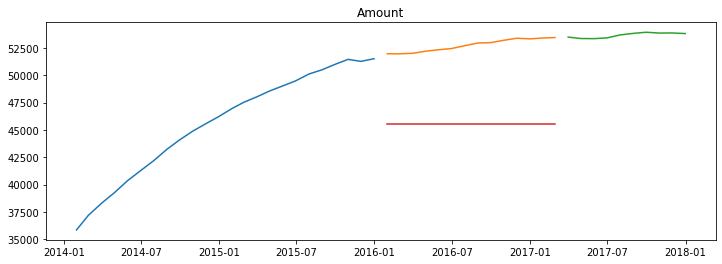

In [58]:
plot_and_eval(target_var)

In [59]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = col)

In [60]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0


# Moving Average

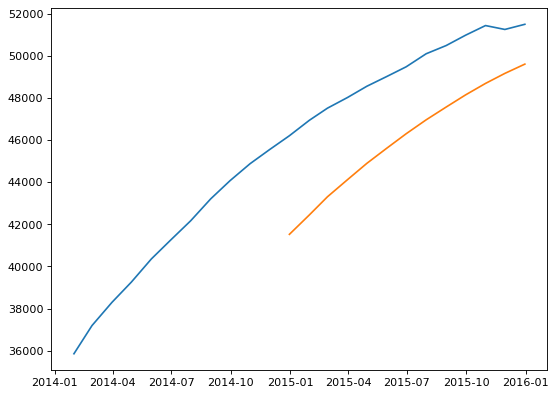

In [63]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(train['Amount'])
plt.plot(train['Amount'].rolling(12).mean())

In [64]:
period = 12

amt = round(train['Amount'].rolling(period).mean().iloc[-1],2)

yhat_df = pd.DataFrame({'Amount': [amt]}, index = validate.index)

In [66]:
yhat_df.head(2)

,Amount
ds,
2016-01-31,49612.92
2016-02-29,49612.92


Amount --RMSE: 3164


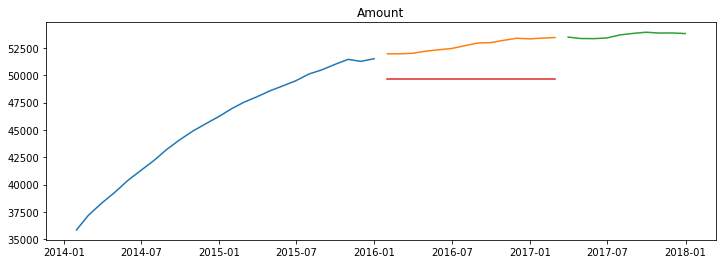

In [67]:
for col in train.columns:
    plot_and_eval(col)

In [69]:
for col in train.columns:
    eval_df = append_eval_df(model_type = f'{period}M moving average', target_var = col)

In [70]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,12M moving average,Amount,3164.0


In [71]:
periods = [1, 3, 4, 6]

for p in periods:
    amt = round(train['Amount'].rolling(p).mean().iloc[-1],2)
    yhat_df = pd.DataFrame({'Amount': [amt]}, index = validate.index)
    eval_df = append_eval_df(model_type = f'{p}M moving average', target_var = col)

In [72]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,12M moving average,Amount,3164.0
3,1M moving average,Amount,1343.0
4,3M moving average,Amount,1436.0
5,4M moving average,Amount,1533.0
6,6M moving average,Amount,1847.0


# Holt's Linear Trend

Amount 



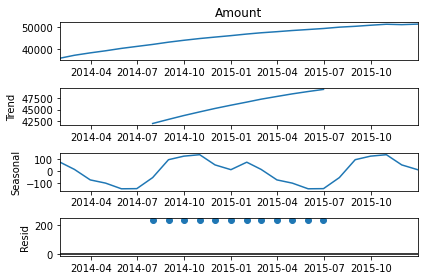

In [77]:
import statsmodels.api as sm

for col in train.columns:
    print(col, '\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [78]:
for col in train.columns:
    # creating the holt object
    model = Holt(train[col], exponential = False)
    # fit the model providing the alpha/smoothing level and beta/smoothing slope
    model = model.fit(smoothing_level = .1,
                      smoothing_slope = .1,
                      optimized = False
                     )
    # predict/forcast providing the start and end dates
    yhat = model.predict(start = validate.index[0], end = validate.index[-1])

    yhat_df[col] = round(yhat, 2)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [80]:
yhat_df

,Amount
ds,
2016-01-31,56126.18
2016-02-29,56803.68
2016-03-31,57481.18
2016-04-30,58158.68
2016-05-31,58836.18
2016-06-30,59513.68
2016-07-31,60191.18
2016-08-31,60868.68
2016-09-30,61546.18


Amount --RMSE: 8103


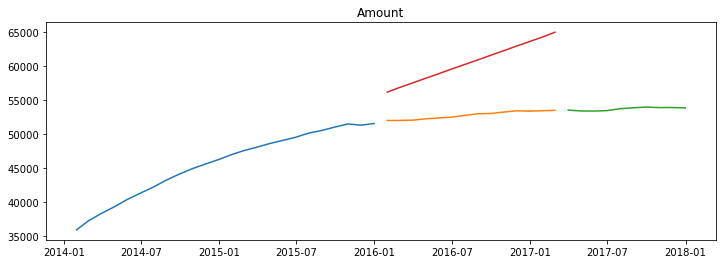

In [81]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', target_var = col)
    plot_and_eval(target_var = col)

In [82]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,12M moving average,Amount,3164.0
3,1M moving average,Amount,1343.0
4,3M moving average,Amount,1436.0
5,4M moving average,Amount,1533.0
6,6M moving average,Amount,1847.0
7,Holts,Amount,8103.0


# Predict based on previous cycle

In [88]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [90]:
len(train)

24

In [91]:
train.diff(12).mean()

Amount    8088.75
dtype: float64

In [95]:
yhat_df = train['2015'] + train.diff(12).mean()

In [96]:
yhat_df = yhat_df.set_index(validate.index)

In [97]:
yhat_df

,Amount
ds,
2016-01-31,55033.75
2016-02-29,55608.75
2016-03-31,56113.75
2016-04-30,56648.75
2016-05-31,57113.75
2016-06-30,57573.75
2016-07-31,58193.75
2016-08-31,58583.75
2016-09-30,59073.75


Amount --RMSE: 5192


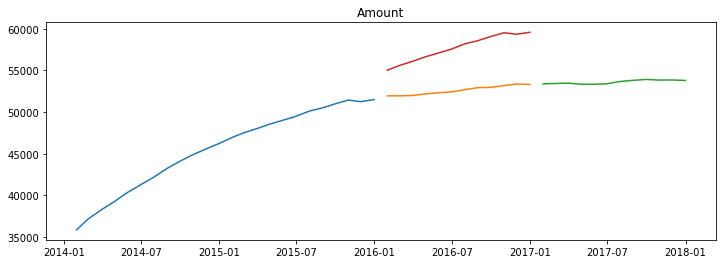

In [98]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'yoy-diff', target_var = col)
    plot_and_eval(target_var = col)

In [99]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,12M moving average,Amount,3164.0
3,1M moving average,Amount,1343.0
4,3M moving average,Amount,1436.0
5,4M moving average,Amount,1533.0
6,6M moving average,Amount,1847.0
7,Holts,Amount,8103.0
8,yoy-diff,Amount,5192.0


In [101]:
compare_df = pd.concat([yhat_df.Amount, validate.Amount], axis=1)
compare_df.columns = ['yhat', 'actual']
compare_df['error'] = compare_df.actual - compare_df.yhat
compare_df['squared_error'] = compare_df.error * compare_df.error
compare_df

,yhat,actual,error,squared_error
ds,,,,
2016-01-31,55033.75,51955.0,-3078.75,9.478702e+06
2016-02-29,55608.75,51955.0,-3653.75,1.334989e+07
2016-03-31,56113.75,52000.0,-4113.75,1.692294e+07
2016-04-30,56648.75,52190.0,-4458.75,1.988045e+07
2016-05-31,57113.75,52325.0,-4788.75,2.293213e+07
2016-06-30,57573.75,52435.0,-5138.75,2.640675e+07
2016-07-31,58193.75,52695.0,-5498.75,3.023625e+07
2016-08-31,58583.75,52940.0,-5643.75,3.185191e+07
2016-09-30,59073.75,52975.0,-6098.75,3.719475e+07


In [104]:
eval_df.sort_values('rmse')

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
3,1M moving average,Amount,1343.0
4,3M moving average,Amount,1436.0
5,4M moving average,Amount,1533.0
6,6M moving average,Amount,1847.0
2,12M moving average,Amount,3164.0
8,yoy-diff,Amount,5192.0
1,simple_average,Amount,7181.0
7,Holts,Amount,8103.0


# Conclusion
- The "Last Observed Value" gave me the best model. 

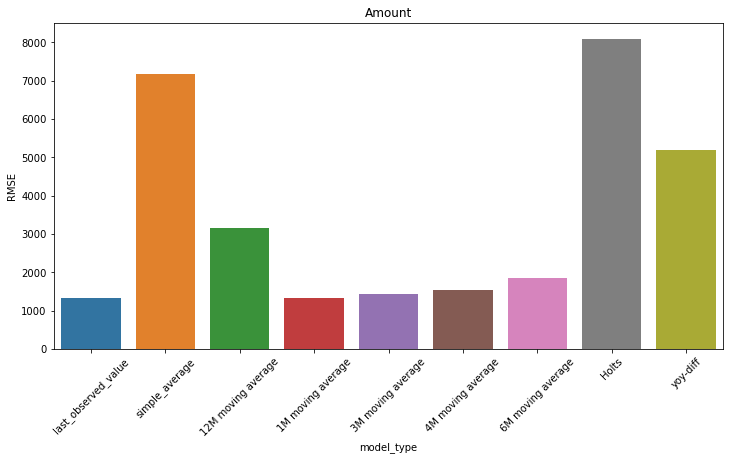

In [105]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

# Predict Test

In [107]:
amt = validate['Amount'][-1:][0]
yhat_df = pd.DataFrame({'Amount': [amt]}, index = test.index)
yhat_df.head(2)

,Amount
ds,
2017-01-31,53320.0
2017-02-28,53320.0


Amount --RMSE: 875


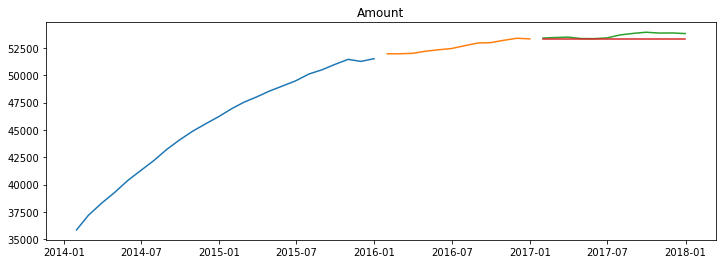

In [108]:
for col in test.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)
    plot_and_eval(col)

In [109]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,12M moving average,Amount,3164.0
3,1M moving average,Amount,1343.0
4,3M moving average,Amount,1436.0
5,4M moving average,Amount,1533.0
6,6M moving average,Amount,1847.0
7,Holts,Amount,8103.0
8,yoy-diff,Amount,5192.0
9,last_observed_value,Amount,875.0


# Takeaways
- performed "last observed value" model on Test and got RMSE = 875. The lowest of all previous models. 